# Model evaluation

In [74]:
#from google.colab import drive

import zipfile
#import gdown
import os

from tqdm import tqdm



import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import normalize

In [75]:
#drive.mount('/content/drive')

# Create proper architecture
`Siamese Unet with feature Differece`

_____________________________________
<pre>
Img1--> Unet endoer--> featuers_vectors_1--> | -----------|
                                             | Features   |
                                             | Difference |--> Decoder -->
                                             | Extraction |          
Img2--> Unet endoer--> featuers_vectors_2--> |------------|

</pre>


In [76]:
# 2) SiamUnet_diff
class SiamUnet_diff(nn.Module):
    def __init__(self, n_classes=1):

        super(SiamUnet_diff, self).__init__()

        #  Encoder -  pretrain module ResNet18 ( train on ImageNet dataset)
        self.encoder = models.resnet18(pretrained=True)  # Wczytywanie enkodera
        self.encoder_layers = list(self.encoder.children())  # Rozbicie na poszczególne warstwy

        #  Enocder Layers (seperate for groups):
        # ___Conv1
        # Conv2d(3, 64, 7x7, stride=2) + BatchNorm2d(64) + ReLU
        # Input: (256, 256, 3) --> Output: (64, 128, 128)
        self.conv1 = nn.Sequential(*self.encoder_layers[:3])
        # ___Conv2
        # MaxPool2d(3x3, stride=2)
        # layer1 – 2 x residual block (64 -> 64)
        # Input: (64, 128, 128) --> Output: (64, 64, 64)
        self.conv2 = nn.Sequential(*self.encoder_layers[3:5])
        # ___Conv3
        # layer2 – 2 x residual block (64 → 128)
        # Input (64, 64, 64) --> Output (128, 32, 32)
        self.conv3 = self.encoder_layers[5]
        # __Conv4
        # layer3 – 2 x residual block (128 → 256)
        # Input (128, 32, 32) --> Output (256, 16, 16)
        self.conv4 = self.encoder_layers[6]
        # __Conv5
        # layer4 – 2 x residual block (256 → 512)
        # Input (256, 16, 16) --> Output (512, 8, 8)
        self.conv5 = self.encoder_layers[7]

        #  Dekoder – "U-Net style upsampling" (trenowany od zera)

        #
        self.up1 = self.up_block(512, 256) # (512,8,8)    -> (256,16,16)
        self.up2 = self.up_block(256, 128) # (256,16,16)  -> (128,32,32)
        self.up3 = self.up_block(128, 64)  # (128,32,32)  -> (64,64,64)
        self.up4 = self.up_block(64, 64)   # (64,64,64)   -> (64,128,128)
        self.up5 = self.up_block(64, 64)   # (64,128,128) -> (64,256,256)

        #  Finalna warstwa - mapa zmian
        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward_once(self, x):
        # Pass one image through encoder
        x1 = self.conv1(x)  # 64 f
        x2 = self.conv2(x1) # 64 f
        x3 = self.conv3(x2) # 128 f
        x4 = self.conv4(x3) # 256 f
        x5 = self.conv5(x4) # 512 f
        return x1, x2, x3, x4, x5


    def up_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),  # upsampling
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )


    def forward(self, x1, x2):
        # Pass both images through encoder, comare features and decode

        # 1 Pass both images
        f1 = self.forward_once(x1)
        f2 = self.forward_once(x2)

         #  Calculate abs difference between features in differen 'scales'
        diff5 = torch.abs(f1[4] - f2[4])  # warstwa 5
        up4 = self.up1(diff5)

        diff4 = torch.abs(f1[3] - f2[3])  # warstwa 4
        up3 = self.up2(up4 + diff4)

        diff3 = torch.abs(f1[2] - f2[2])  # warstwa 3
        up2 = self.up3(up3 + diff3)

        diff2 = torch.abs(f1[1] - f2[1])  # warstwa 2
        up1 = self.up4(up2 + diff2)

        out = self.up5(up1)

        out = self.final(out)
        return out
        # return torch.sigmoid(out)




In [77]:
## Create net
model = SiamUnet_diff()

# Data loader
- Create data loader
- import test data set


In [78]:

class S2Looking_DataSet(Dataset):  #Inheriting after DataSet from pytorch - it is required

  def __init__(self, dir1, dir2, dir_mask, augment=None):
        """
        dir1 - directory with images from one period
        dir2 - directory with images from second period
        dir_mask - directory with masks
        transform - idk yet
        """
        self.path_i1 = sorted([os.path.join(dir1, f) for f in os.listdir(dir1) if f.endswith('.png')]) # list of paths to specific image
        self.path_i2 = sorted([os.path.join(dir2, f) for f in os.listdir(dir2) if f.endswith('.png')])
        self.mask_path = sorted([os.path.join(dir_mask, f) for f in os.listdir(dir_mask) if f.endswith('.png')])
        self.augment = augment


        # Norm according to ImageNet requirement (for ResNet)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])


  def __len__(self):
        return len(self.mask_path)

  def __getitem__(self, idx):
        # import images
        I1 = cv2.imread(self.path_i1[idx])
        I2 = cv2.imread(self.path_i2[idx])
        M = cv2.imread(self.mask_path[idx])

        # resize
        I1 = cv2.resize(I1, (256, 256))
        I2 = cv2.resize(I2, (256, 256))
        M = cv2.resize(M, (256, 256))

        # normalize
        I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2RGB)
        I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2RGB)

        M = cv2.cvtColor(M, cv2.COLOR_BGR2GRAY)
        _, M = cv2.threshold(M, 127, 255, cv2.THRESH_BINARY)
        M = M.astype(np.float32) / 255.0

        I1 = torch.from_numpy(I1).permute(2, 0, 1).float() / 255.0
        I2 = torch.from_numpy(I2).permute(2, 0, 1).float() / 255.0
        I1 = self.normalize(I1)
        I2 = self.normalize(I2)
        M = torch.from_numpy(M).unsqueeze(0).float()

        return I1, I2, M



# Load weights to model


In [79]:

#weights_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking_wagi\best_weights_train_epoch_99.pth'
weights_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking_wagi\best_weights_train_epoch_53.pth'
#weights_path = r'C:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking_wagi\best_weights_train_epoch_14.pth'
state_dict = torch.load(weights_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)
model.eval()

C:\Users\jango\AppData\Local\Temp\ipykernel_19352\1727355780.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=torch.dev

SiamUnet_diff(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluation
Calculate metrics for test data sets.
Used metrics:
<!-- Precision = precision_sum / len(dataset_test)
Recall = recall_sum / len(dataset_test)

F1 = 2 / ( (1/Precision) + (1/Recall) )

Accuracy = correct_pixels / total_pixels
iou = intersection / union if union > 0 else 0.0 -->
1. Accuracy - How many pixels are classified correctly <br>
`Accuracy= (TP+TN) / (TP+TN+FP+FN)`

2. IoU - Measure how detected area overlap on ground truth <br>
`IoU = TP / (TP + FP + FN)`

3. Precision - How many pixels classified as object, is classified correctly <br>
`Precision = TP / (TP + FP)`

4. Recall - How many correct pixels are detected  <br>
`Precision = TP / (TP + FN)`

5. F1 Score <br>
`F1 = 2 / ( (1/Precision) + (1/Recall) )`

In [81]:
def metricTP(pred, mask):
  return ((pred == 1) & (mask == 1)).sum().item()

def metricFP(pred, mask):
  return ((pred == 1) & (mask == 0)).sum().item()

def metricFN(pred, mask):
  return ((pred == 0) & (mask == 1)).sum().item()

def metricTN(pred, mask):
  return ((pred == 0) & (mask == 0)).sum().item()


In [82]:
root_path = r'c:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking'

img1_path_test = os.path.join(root_path, 'test', 'Image1')
img2_path_test = os.path.join(root_path, 'test', 'Image2')
label_path_test = os.path.join(root_path, 'test', 'label')

dataset_test = S2Looking_DataSet(img1_path_test, img2_path_test, label_path_test)

model.eval()


criterion = nn.BCEWithLogitsLoss()

# all_preds = []
# all_targets = []

correct_pixels = 0
total_pixels = 0
intersection = 0
union = 0

precision_sum = 0
recall_sum = 0
Accuracy_sum = 0
IoU_sum = 0

good_example_list = []
bad_example_list = []
act_idx = 1
with torch.no_grad():

    for input1, input2, masks in tqdm(dataset_test, desc="Model evaluation"):

        input1 = input1.unsqueeze(0).to(device)
        input2 = input2.unsqueeze(0).to(device)
        masks = masks.unsqueeze(0).to(device)

        output = model(input1, input2)

        prediction = torch.sigmoid(output).squeeze().cpu().numpy()  # → [H, W], wartości 0–1

        prediction_mask = (prediction > 0.05).astype(np.uint8)

        masks = masks.squeeze().cpu().numpy()
        TP = metricTP(prediction_mask, masks)
        FN = metricFN(prediction_mask, masks)
        FP = metricFP(prediction_mask, masks)
        TN = metricTN(prediction_mask, masks)
        if TP != 0:

          Accuracy_sum += (TP+TN) / (TP+TN+FP+FN)
          IoU_sum += TP / (TP + FP + FN)
          precision_sum += TP / (TP + FP)
          recall_act = TP / (TP + FN)
          recall_sum += recall_act



Accuracy = Accuracy_sum / len(dataset_test)
IoU = IoU_sum / len(dataset_test)
Precision = precision_sum / len(dataset_test)
Recall = recall_sum / len(dataset_test)
F1 = 2 / ( (1/Precision) + (1/Recall) )



# Accuracy = correct_pixels / total_pixels
# iou = intersection / union if union > 0 else 0.0
print(f'Model evaluation:\nAccuracy: {Accuracy}/1\nIoU: {IoU}')
print(f'Precision: {Precision}')
print(f'Recall: {Recall}')
print(f'F1: {F1}')




Model evaluation: 100%|██████████| 1000/1000 [01:34<00:00, 10.55it/s]

Model evaluation:
Accuracy: 0.8813651733398438/1
IoU: 0.24541012917091848
Precision: 0.36124962148356843
Recall: 0.45442561301091194
F1: 0.4025157899868575


good example list: []
bad example list: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 837, 838, 839, 840, 841, 842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 900, 901, 902, 903, 904, 905, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 917, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236]
Model evaluation:
Accuracy: 0.8899214883232682/1
IoU: 0.22294722362631214
Precision: 0.315360125847068
Recall: 0.4631100508588384
F1: 0.3752139729690875

Model evaluation:
Accuracy: 0.99432373046875/1
IoU: 0.5020080321285141
Precision: 0.5259467040673211
Recall: 0.9168704156479217
F1: 0.6684491978609626


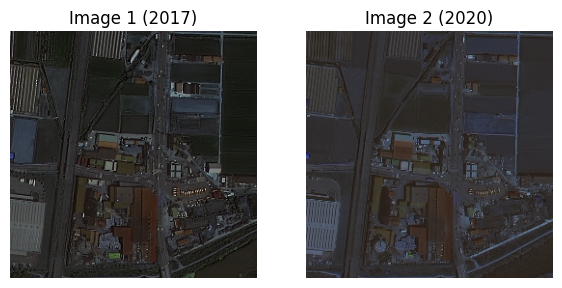

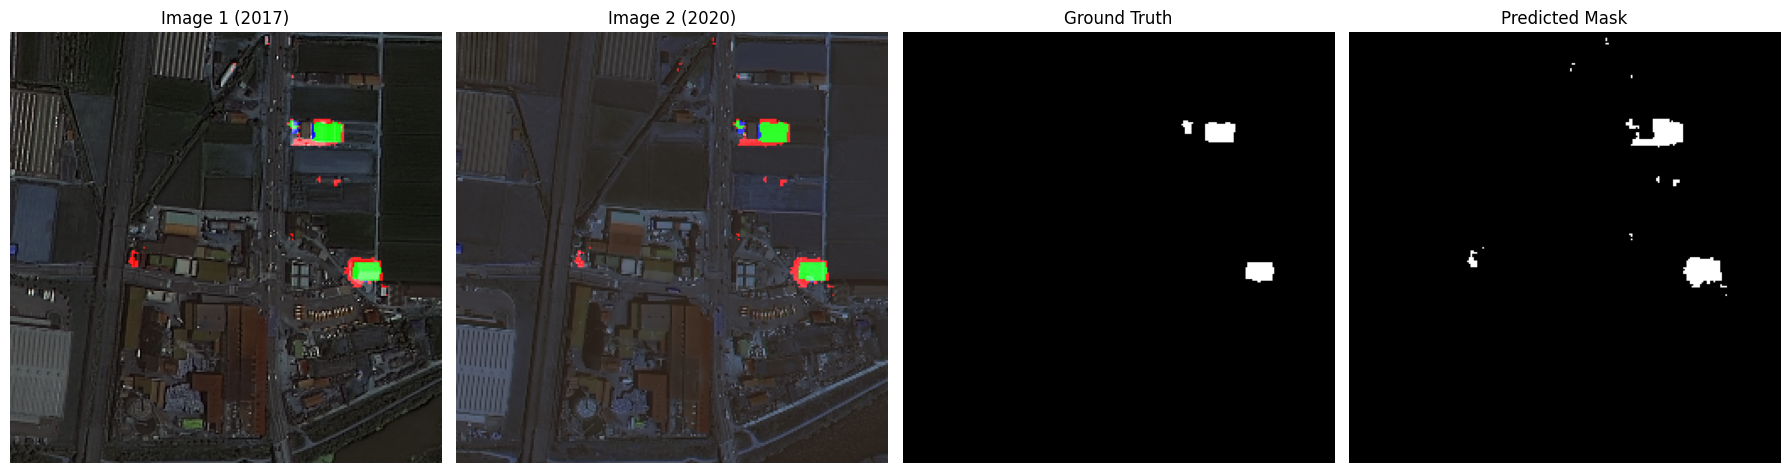

In [83]:
# Pobierz jedną próbkę
root_path = r'c:\Users\jango\Desktop\studia\magisterka\ZAW_projekt\Dataset\S2Looking'


img1_path_test = os.path.join(root_path, 'test', 'Image1')
img2_path_test = os.path.join(root_path, 'test', 'Image2')
label_path_test = os.path.join(root_path, 'test', 'label')

dataset_test = S2Looking_DataSet(img1_path_test, img2_path_test, label_path_test)


i = 743


heatmap = True
in1, in2, mask = dataset_test[i]

in1 = in1.unsqueeze(0).to(device)  # Add batch dim
in2 = in2.unsqueeze(0).to(device)  # Add batch dim
mask = mask.squeeze().cpu().numpy()  # Delete batch dim from Ground truth (to disp)

img1_name = sorted(os.listdir(img1_path_test))[i]
img2_name = sorted(os.listdir(img2_path_test))[i]
img1 = cv2.imread(os.path.join(img1_path_test, img1_name))
img2 = cv2.imread(os.path.join(img2_path_test, img2_name))
img1 = cv2.resize(img1, (256, 256))
img2 = cv2.resize(img2, (256, 256))


# Pass trhough model
model.eval()
with torch.no_grad():
    output = model(in1, in2)
    # prediction = output.squeeze().cpu().numpy()  # → [H, W], wartości 0–1
    prediction = torch.sigmoid(output).squeeze().cpu().numpy()  # → [H, W], wartości 0–1

prediction_mask = (prediction > 0.01).astype(np.uint8)

# Show result
fig, axs = plt.subplots(1, 2, figsize=(7, 4))
axs[0].imshow(img1)
axs[0].set_title("Image 1 (2017)")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Image 2 (2020)")
axs[1].axis("off")

if heatmap:
   TP_mask = (mask == 1) & (prediction_mask == 1) # correct detection
   FP_mask = (mask == 0) & (prediction_mask == 1) # it shouldn't be detected  but there is
   FN_mask = (mask == 1) & (prediction_mask == 0) # it should be detected  but it's not



   img1[FP_mask,0] = 255 #np.ones((255,255))
   img2[FP_mask,0] = 255 #np.ones((255,255))

   img1[TP_mask,1] = 255 #np.ones((255,255))
   img2[TP_mask,1] = 255 #np.ones((255,255))

   img1[FN_mask,2] = 255 #np.ones((255,255))
   img2[FN_mask,2] = 255 #np.ones((255,255))

# Calc metrics
Tp = metricTP(prediction_mask, mask)
Fp = metricFP(prediction_mask, mask)
Fn = metricFN(prediction_mask, mask)
Tn = metricTN(prediction_mask, mask)
if Tp != 0:
  Accuracy = (Tp+Tn) / (Tp+Tn+Fp+Fn)
  IoU = Tp / (Tp + Fp + Fn)
  precision = Tp / (Tp + Fp)
  recall = Tp / (Tp + Fn)
  f1 = 2 / ( (1/precision) + (1/recall) )

  print(f'Model evaluation:\nAccuracy: {Accuracy}/1\nIoU: {IoU}')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1: {f1}')
else:
  print(f'There is no correct detection - it is not possible to calc metrics')

# Show result
fig, axs = plt.subplots(1, 4, figsize=(18, 6))
axs[0].imshow(img1)
axs[0].set_title("Image 1 (2017)")
axs[0].axis("off")

axs[1].imshow(img2)
axs[1].set_title("Image 2 (2020)")
axs[1].axis("off")

# axs[2].imshow(mask, cmap='gray')
axs[2].imshow(mask, cmap='gray')
axs[2].set_title("Ground Truth")
axs[2].axis("off")

axs[3].imshow(prediction_mask, cmap='gray')
axs[3].set_title("Predicted Mask")
axs[3].axis("off")

plt.tight_layout()
plt.show()

# Dla zbioru testowego

## Good working example:
 - 743, 859, 123, 274 (fajnie pokazuje jak działa - dziura w trawie, do białej ziemi albo coś takiego, wykryte jako dach )  
## Bad working example:
- 23, 183 (dziwnwy przykład, gdzie są takie tunele na polu)
## Interesting behavoiur:
- 333 ewidentie moim zdaniem zmienił się parking przy domku w centralnej części obrazu, nasza sieć to zaznaczyła, a ground truth nie zaznaczono tego. czerwony kształt taki jak serce albo nerka albo ogórek. <br>
Poniżej widzimy inny obszar, taki szerszy, tam prawdopodbnie bardzo duże róznice w jasności spowodowały, że sieć "widzi" że budynek się pojawił, wcześniej zlał się z tłem
- 10 - czuje się nie sprawiedliwie potraktowany przez tego kto to etykietował, nasza sieć ewidentnie wykyła coś, co bym zaliczył do zmiany zabudowania XD


# Dla zbioru treningowego

- 734, 111

# WNioski

- duże różnice w jasności obrazów bardzo zaburzają działanie sieci
(szczególnie, jak w obrazie 333 ze zbioru testowego, niebieskie dachy + plus ciemne zdjęcia )

- sieć jest bardzo wrażliwa na zmiany, niekoniecznie budnków. Wykrywa więskze zmiany np. w polach rolnych.